In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import os
import keras.backend as K

if K.backend() == "tensorflow":
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
data = pd.read_csv('./data/btc_hourly_2018-2022.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data = data.set_index('timestamp')
data.head(2)

,open,high,low,close,volume_btc,volume_usd
timestamp,,,,,,
2022-03-01 00:00:00,43221.71,43626.49,43185.48,43312.27,52.056320,2.254677e+06
2022-02-28 23:00:00,43085.30,43364.81,42892.37,43178.98,106.816103,4.612210e+06


In [3]:
# split data
split_date = '25-Jun-2021'
data_train = data.loc[data.index <= split_date].copy()
data_test = data.loc[data.index > split_date].copy()

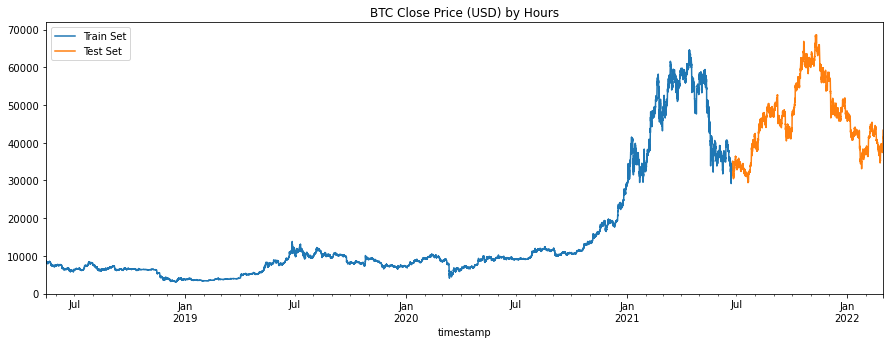

In [4]:
price_train = pd.DataFrame(data_train.loc[:, 'close'])
price_test = pd.DataFrame(data_test.loc[:, 'close'])

fig, ax = plt.subplots(figsize=(15, 5), facecolor='white')
_ = price_train \
    .rename(columns={'close': 'Train Set'}) \
    .join(price_test.rename(columns={'close': 'Test Set'}), how='outer') \
    .plot(ax=ax, title='BTC Close Price (USD) by Hours')

In [5]:
def construct_input(data:pd.DataFrame, sc:MinMaxScaler, timesteps=5):
    y_idx = data.columns.get_loc('close')
    data_set = data.values
    data_set = sc.transform(data_set)

    X = data_set[0:len(data_set) - timesteps]
    X = np.array([X[i:i+timesteps] for i in range(len(X)) if i < len(X) - timesteps])
    y = data_set[timesteps:len(X)+timesteps, y_idx]

    return X, y

In [6]:
timesteps = 5
sc = MinMaxScaler()
sc.fit(data_train.values)

X_train, y_train = construct_input(data_train, sc, timesteps=5)
X_test, y_test = construct_input(data_test, sc, timesteps=5)

### Model Architecture (LSTM)

In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation


model = Sequential()
model.add(LSTM(128,activation="sigmoid", input_shape=(5,6)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 128)               69120     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 69,249
Trainable params: 69,249
Non-trainable params: 0
_________________________________________________________________


### Training

In [8]:
epochs = 10
batch_size = 50
iter_per_save = 10
save_freq = int(iter_per_save * (y_train.shape[0] / batch_size))

checkpoint_path = "checkpoints/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1, 
                                                 save_freq=save_freq)

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[cp_callback])

model.save("models/{}_{}".format('lstm_model', epochs))

Epoch 1/10
546/546 [==============================] - 3s 4ms/step - loss: 0.0216
Epoch 2/10
546/546 [==============================] - 2s 4ms/step - loss: 0.0030
Epoch 3/10
546/546 [==============================] - 2s 4ms/step - loss: 0.0014
Epoch 4/10
546/546 [==============================] - 2s 4ms/step - loss: 9.6341e-04
Epoch 5/10
546/546 [==============================] - 2s 5ms/step - loss: 7.5154e-04
Epoch 6/10
546/546 [==============================] - 2s 5ms/step - loss: 6.3965e-04
Epoch 7/10
546/546 [==============================] - 2s 4ms/step - loss: 5.3752e-04
Epoch 8/10
546/546 [==============================] - 2s 5ms/step - loss: 5.0529e-04
Epoch 9/10
546/546 [==============================] - 2s 4ms/step - loss: 4.5826e-04
Epoch 10/10
538/546 [============================>.] - ETA: 0s - loss: 4.2414e-04
Epoch 00010: saving model to checkpoints\cp-0010.ckpt
546/546 [==============================] - 2s 5ms/step - loss: 4.2439e-04
INFO:tensorflow:Assets written to: mo

### Prediction results

In [1]:
sc_pred = MinMaxScaler()
train_set = data_train['close'].values
train_set = np.reshape(train_set, (len(train_set), 1))
sc_pred.fit(train_set)

print(X_test)

predicted_price = model.predict(X_test)
predicted_price = sc_pred.inverse_transform(predicted_price)

result = pd.DataFrame(data_test.loc[:, 'close']).head(len(predicted_price))
result['prediction'] = predicted_price
result = result.rename(columns={'close': 'actual price'})

fig, ax = plt.subplots(figsize=(15, 5), facecolor='white')
ax = result.plot(ax=ax)
ax.set_xbound(lower='10-01-2021', upper='10-08-2021')

NameError: name 'MinMaxScaler' is not defined

### Performance Evaluation

In [10]:
#calculate MSE and MAE
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(y_true=result['actual price'],
                   y_pred=result['prediction'])
mae = mean_absolute_error(y_true=result['actual price'],
                   y_pred=result['prediction'])

print(f"mse: {mse}\nmae: {mae}")

mse: 361116.68355084775
mae: 450.33025903295766
